In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt

from keras import backend as K
from keras.models import Model
from keras.layers import Input
from keras.layers.core import Flatten
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.pooling import MaxPooling2D
from keras.activations import relu
from keras.layers.merge import Concatenate
from keras.layers.wrappers import TimeDistributed

Using Theano backend.
Using cuDNN version 5110 on context None
Mapped name None to device cuda0: GeForce GTX 1080 (0000:01:00.0)


# Building a simple model
This model will have two layers of a simple ConvLSTM2D

lstm(R1) <---- A1 
 |              ^
 |              |
upsample       conv
 |              | 
lstm(R0) <---- A0 <--conv-- Inp

## Questions:
1. How do I choose the number of filters in every layer?

In [2]:
batch_size = 10
original_dim = (9, 20, 20, 1)
epochs = 50

#Input image to the network
x = Input(shape=original_dim) # (batch_size, no_frames, im_rows, im_cols, no_filters) = (10, 10, 20, 20, 1)

#1st layer convolution stack
# output size (10, 10, 20, 20, 100)
A1_conv = TimeDistributed(Conv2D(filters=50, kernel_size=(3,3), padding='same', data_format="channels_last", activation="relu"))(x)
# output size (10, 10, 10, 10, 100)
A1 = TimeDistributed(MaxPooling2D(pool_size=2, data_format="channels_last"))(A1_conv)

#2nd layer convolution stack 
# output size (10, 10, 13, 13, 200)
#A1_intermediate = TimeDistributed(Conv2D(filters=200, kernel_size=(3,3), padding='same', data_format="channels_last", activation="relu"))(A0)
# output size (10, 10, 11, 11, 400)
#A1 = TimeDistributed(Conv2D(filters=400, kernel_size=(3,3), padding='same', data_format="channels_last", activation="relu"))(A0)

# If we have ConvLSTM, do we need 2 separate layers of convolution? I think the LSTM should get the input from the second 
# # output size (10, 10, 10, 10, 400)
R1 = ConvLSTM2D(filters = 100, kernel_size=(3,3), padding='same', data_format="channels_last", return_sequences=True)(A1)

R0_input_topdown = TimeDistributed(UpSampling2D(size=(2,2)))(R1)
R0_input_lateral = x
R0_input = Concatenate(axis=-1)([R0_input_topdown, R0_input_lateral])
R0 = ConvLSTM2D(filters = 100, kernel_size=(3,3), padding='same', data_format="channels_last", return_sequences=True)(R0_input)

output = TimeDistributed(Conv2D(filters=1, kernel_size=(3,3), padding='same', data_format="channels_last"))(R0)

model = Model(inputs=x, outputs=output)

for count in range(8):
    print(model.layers[count].output_shape)

(None, 9, 20, 20, 1)
(None, 9, 20, 20, 50)
(None, 9, 10, 10, 50)
(None, 9, 10, 10, 100)
(None, 9, 20, 20, 100)
(None, 9, 20, 20, 101)
(None, 9, 20, 20, 100)
(None, 9, 20, 20, 1)


In [3]:
model.compile(optimizer='rmsprop', loss='mse', metrics=['accuracy'])

## Loading the data

In [4]:
import hickle as hkl
datapath = '/home/ybansal/Documents/Research/stochastic-prednet/Data/confused_ball/train.hkl'

In [5]:
f = open(datapath, 'r')
data_container = hkl.load(f)
f.close()

In [6]:
X_train = data_container['videos'][:,0:9]
Y_train = data_container['videos'][:,1:10]

In [7]:
model.fit(X_train, Y_train, epochs=10, batch_size=10, verbose=2)

Epoch 1/10
17s - loss: 0.0202 - acc: 0.0000e+00
Epoch 2/10
17s - loss: 0.0132 - acc: 0.0000e+00
Epoch 3/10
17s - loss: 0.0120 - acc: 0.0000e+00
Epoch 4/10
17s - loss: 0.0113 - acc: 0.0000e+00
Epoch 5/10
17s - loss: 0.0110 - acc: 0.0000e+00
Epoch 6/10
17s - loss: 0.0109 - acc: 0.0000e+00
Epoch 7/10
17s - loss: 0.0108 - acc: 0.0000e+00
Epoch 8/10
17s - loss: 0.0108 - acc: 0.0000e+00
Epoch 9/10
17s - loss: 0.0108 - acc: 0.0000e+00
Epoch 10/10
17s - loss: 0.0107 - acc: 0.0000e+00


In [8]:
Y_predicted = model.predict(X_train)

In [9]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [10]:
i=8

nt = 9
gs = gridspec.GridSpec(3, nt)
gs.update(wspace=0., hspace=0.)
for t in range(nt):
        plt.subplot(gs[t])
        plt.imshow(X_train[i,t,:,:,0], interpolation='none')
        plt.gray()
        plt.tick_params(axis='both', which='both', bottom='off', top='off', left='off', right='off', labelbottom='off', labelleft='off')
        if t==0: plt.ylabel('Actual', fontsize=10)

        plt.subplot(gs[t + nt])
        plt.imshow(Y_predicted[i,t,:,:,0], interpolation='none')
        plt.gray()
        plt.tick_params(axis='both', which='both', bottom='off', top='off', left='off', right='off', labelbottom='off', labelleft='off')
        if t==0: plt.ylabel('Predicted', fontsize=10)
            
        plt.subplot(gs[t + 2*nt])
        plt.imshow(X_train[i,t,:,:,0]-Y_predicted[0,t,:,:,0], interpolation='none')
        plt.gray()
        plt.tick_params(axis='both', which='both', bottom='off', top='off', left='off', right='off', labelbottom='off', labelleft='off')
        if t==0: plt.ylabel('Predicted', fontsize=10)

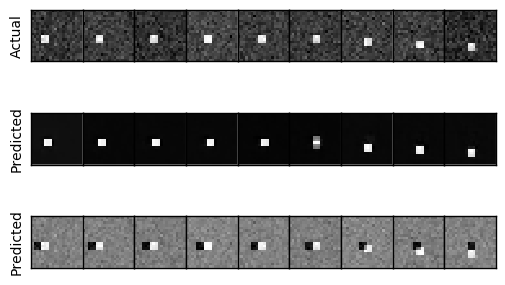

In [11]:
plt.show()

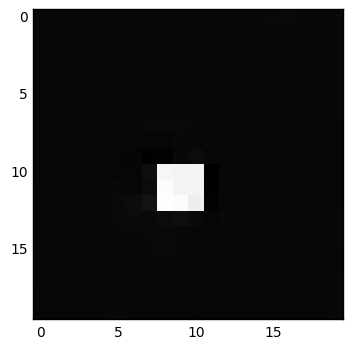

In [16]:
plt.imshow(Y_predicted[i,3,:,:,0], interpolation='none')
plt.show()

In [ ]:
for i in range(9):
    plt.imshow(Y_predicted[3,i,:,:,0], interpolation='none')
    plt.savefig('/home/ybansal/Documents/Research/stochastic-prednet/Figures/BallPredUp' + str(i)+'.png')
plt.show()

In [ ]:
data_container['directions']

In [ ]:
data_container['trajectories'][:,0,0]